In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from IPython.core.display import display, HTML
from cross_validation import *
from build_polynomial import *
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


## Load the training data into feature matrix, class labels, and event ids:

In [3]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
#y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
#print(y.shape, tX.shape, ids.shape)

In [4]:
y0, tX0, id0 = load_data_jet_number(DATA_TRAIN_PATH, 0, sub_sample=False)
y1, tX1, id1 = load_data_jet_number(DATA_TRAIN_PATH, 1, sub_sample=False)
y2, tX2, id2 = load_data_jet_number(DATA_TRAIN_PATH, 2, sub_sample=False)
y3, tX3, id3 = load_data_jet_number(DATA_TRAIN_PATH, 3, sub_sample=False)
tX0_standardized, tX0_mean, tX0_std= standardize(tX0)
tX1_standardized, tX1_mean, tX1_std= standardize(tX1)
tX2_standardized, tX2_mean, tX2_std= standardize(tX2)
tX3_standardized, tX3_mean, tX3_std= standardize(tX3)

## Do your thing crazy machine learning thing here :) ...

In [5]:
#tX0_standardized = np.c_[np.ones((y0.shape[0], 1)), tX0_standardized] #VERY IMPORTANT
y0=y0.reshape(-1,1)
y0=(y0+1)/2
#tX1_standardized = np.c_[np.ones((y1.shape[0], 1)), tX1_standardized] #VERY IMPORTANT
y1=y1.reshape(-1,1)
y1=(y1+1)/2
#tX2_standardized = np.c_[np.ones((y2.shape[0], 1)), tX2_standardized] #VERY IMPORTANT
y2=y2.reshape(-1,1)
y2=(y2+1)/2
#tX3_standardized = np.c_[np.ones((y3.shape[0], 1)), tX3_standardized] #VERY IMPORTANT
y3=y3.reshape(-1,1)
y3=(y3+1)/2

In [6]:
#[w,loss]=reg_logistic_regression(y0, build_poly(tX0_standardized,1), 0.001, np.ones((tX0_standardized.shape[1]+1, 1))/100, 50000, 0.000001)

FIRST MATRIX
DEGREE = 2
Lambda = 1e-06
K-Fold =  0
Current iteration = 0 loss = [[0.70245125]]Current iteration = 10000 loss = [[0.5763991]] rate = [[0.12605215]]
Current iteration = 20000 loss = [[1.15692272]] rate = [[0.58052361]]
Current iteration = 30000 loss = [[1.20158503]] rate = [[0.04466232]]
Current iteration = 40000 loss = [[0.65123742]] rate = [[0.55034761]]
Best last loss = [[0.48190209]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.70337695]]Current iteration = 10000 loss = [[0.56819395]] rate = [[0.135183]]
Current iteration = 20000 loss = [[0.57464323]] rate = [[0.00644928]]
Current iteration = 30000 loss = [[0.58020129]] rate = [[0.00555806]]
Current iteration = 40000 loss = [[1.07432612]] rate = [[0.49412483]]
Best last loss = [[0.47829676]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.70254641]]Current iteration = 10000 loss = [[0.59670574]] rate = [[0.10584067]]
Current iteration = 20000 loss = [[0.63426434]] rate = [[

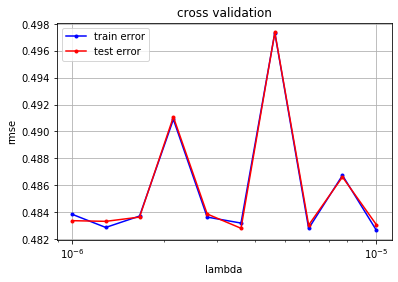

Test best error = 0.48280325943981245for lambda = 3.5938136638046257e-06and degree = 1
SECOND MATRIX
DEGREE = 2
Lambda = 1e-06
K-Fold =  0
Current iteration = 0 loss = [[0.69671713]]Current iteration = 10000 loss = [[0.65215078]] rate = [[0.04456635]]
Current iteration = 20000 loss = [[0.65226507]] rate = [[0.00011429]]
Current iteration = 30000 loss = [[0.68178655]] rate = [[0.02952148]]
Current iteration = 40000 loss = [[0.65631482]] rate = [[0.02547173]]
Best last loss = [[0.57185854]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.7268597]]Current iteration = 10000 loss = [[0.8255193]] rate = [[0.0986596]]
Current iteration = 20000 loss = [[0.65157825]] rate = [[0.17394105]]
Current iteration = 30000 loss = [[0.70237356]] rate = [[0.05079531]]
Current iteration = 40000 loss = [[0.66242987]] rate = [[0.03994369]]
Best last loss = [[0.57849004]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.71388502]]Current iteration = 10000 loss = [[3.77

/home/samuel/MEGAsync/EPFL/master/cs433-ml/projects/project1/scripts/helpers.py:78: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-t))


Current iteration = 10000 loss = [[3.81443817]] rate = [[3.10167119]]
Current iteration = 20000 loss = [[0.74123418]] rate = [[3.07320399]]
Current iteration = 30000 loss = [[1.82347399]] rate = [[1.08223982]]
Current iteration = 40000 loss = [[0.70228579]] rate = [[1.1211882]]
Best last loss = [[0.57221574]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.73247275]]Current iteration = 10000 loss = [[0.67228035]] rate = [[0.06019239]]
Current iteration = 20000 loss = [[0.65330966]] rate = [[0.01897069]]
Current iteration = 30000 loss = [[0.66369406]] rate = [[0.0103844]]
Current iteration = 40000 loss = [[0.68316027]] rate = [[0.01946621]]
Best last loss = [[0.57696265]] after 49999 iterations 
K-Fold =  3
Current iteration = 0 loss = [[0.72118667]]Current iteration = 10000 loss = [[0.66875831]] rate = [[0.05242836]]
Current iteration = 20000 loss = [[0.67448405]] rate = [[0.00572574]]
Current iteration = 30000 loss = [[0.73496069]] rate = [[0.06047664]]
Current it

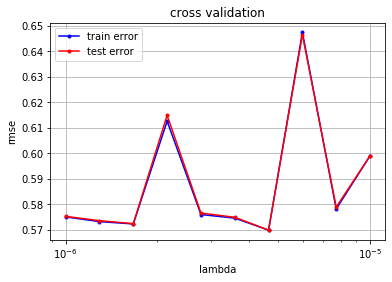

Test best error = 0.569899128370735for lambda = 4.641588833612782e-06and degree = 1
THIRD MATRIX
DEGREE = 2
Lambda = 1e-07
K-Fold =  0
Current iteration = 0 loss = [[0.69325435]]Current iteration = 10000 loss = [[0.72038165]] rate = [[0.0271273]]
Current iteration = 20000 loss = [[0.69691176]] rate = [[0.02346989]]
Current iteration = 30000 loss = [[0.71821365]] rate = [[0.02130189]]
Current iteration = 40000 loss = [[0.8323233]] rate = [[0.11410965]]
Best last loss = [[0.55586449]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.69371095]]Current iteration = 10000 loss = [[0.69650053]] rate = [[0.00278958]]
Current iteration = 20000 loss = [[2.57247163]] rate = [[1.8759711]]
Current iteration = 30000 loss = [[0.72537423]] rate = [[1.8470974]]
Current iteration = 40000 loss = [[0.71759898]] rate = [[0.00777524]]
Best last loss = [[0.5617156]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.69281351]]Current iteration = 10000 loss = [[0.82224234

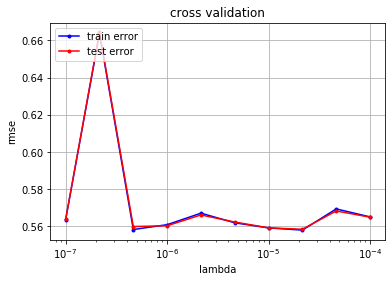

DEGREE = 3
Lambda = 1e-07
K-Fold =  0
Current iteration = 0 loss = [[0.77976919]]Current iteration = 10000 loss = [[5.64645624]] rate = [[4.86668705]]
Current iteration = 20000 loss = [[5.64644574]] rate = [[1.05088121e-05]]
Current iteration = 30000 loss = [[0.92415987]] rate = [[4.72228586]]
Current iteration = 40000 loss = [[5.64645436]] rate = [[4.72229449]]
Best last loss = [[0.81232144]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.70482846]]Current iteration = 10000 loss = [[5.63700803]] rate = [[4.93217956]]
Current iteration = 20000 loss = [[5.63700792]] rate = [[1.06842904e-07]]
Current iteration = 30000 loss = [[0.76585245]] rate = [[4.87115547]]
Current iteration = 40000 loss = [[5.49068881]] rate = [[4.72483636]]
Best last loss = [[0.94185872]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.69313146]]Current iteration = 10000 loss = [[0.71265392]] rate = [[0.01952246]]
Current iteration = 20000 loss = [[0.6963018]] rate = [[0.0

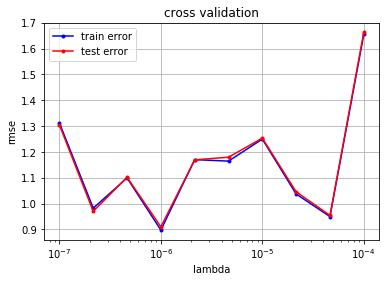

Test best error = 0.5584385370005093for lambda = 2.1544346900318823e-05and degree = 1
FORTH MATRIX
DEGREE = 2
Lambda = 1e-07
K-Fold =  0
Current iteration = 0 loss = [[0.70377265]]Current iteration = 10000 loss = [[0.6764401]] rate = [[0.02733254]]
Current iteration = 20000 loss = [[0.61757562]] rate = [[0.05886449]]
Current iteration = 30000 loss = [[0.6159377]] rate = [[0.00163792]]
Current iteration = 40000 loss = [[1.45866783]] rate = [[0.84273014]]
Best last loss = [[0.56840028]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.7022375]]Current iteration = 10000 loss = [[0.61867889]] rate = [[0.08355861]]
Current iteration = 20000 loss = [[0.65534917]] rate = [[0.03667029]]
Current iteration = 30000 loss = [[0.61835231]] rate = [[0.03699687]]
Current iteration = 40000 loss = [[0.81344794]] rate = [[0.19509563]]
Best last loss = [[0.55257112]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.71114252]]Current iteration = 10000 loss = [[0.6406

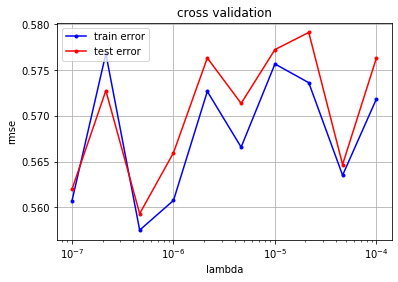

DEGREE = 3
Lambda = 1e-07
K-Fold =  0
Current iteration = 0 loss = [[1.11676014]]Current iteration = 10000 loss = [[7.9966438]] rate = [[6.87988366]]
Current iteration = 20000 loss = [[0.81729251]] rate = [[7.17935129]]
Current iteration = 30000 loss = [[3.36087244]] rate = [[2.54357992]]
Current iteration = 40000 loss = [[0.63379731]] rate = [[2.72707513]]
Best last loss = [[0.86867319]] after 49999 iterations 
K-Fold =  1
Current iteration = 0 loss = [[0.78026773]]Current iteration = 10000 loss = [[3.45211409]] rate = [[2.67184636]]
Current iteration = 20000 loss = [[0.86831375]] rate = [[2.58380034]]
Current iteration = 30000 loss = [[3.11053642]] rate = [[2.24222267]]
Current iteration = 40000 loss = [[0.67832]] rate = [[2.43221642]]
Best last loss = [[1.22137818]] after 49999 iterations 
K-Fold =  2
Current iteration = 0 loss = [[0.73000863]]Current iteration = 10000 loss = [[0.63073661]] rate = [[0.09927202]]
Current iteration = 20000 loss = [[7.99109962]] rate = [[7.36036301]]
C

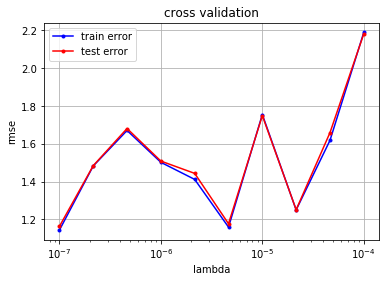

Test best error = 0.5593191572113364for lambda = 4.641588833612782e-07and degree = 1


In [7]:
k_fold=4
seed=5
degree=4 
lower_lambda=-7
upper_lambda=-1
print("FIRST MATRIX")
weights_0, loss_0, deg0 = cross_validation_best_weight(y0, tX0_standardized, k_fold, 3, seed, -6, -5, "jet0")
print("SECOND MATRIX")
weights_1, loss_1, deg1 = cross_validation_best_weight(y1, tX1_standardized, k_fold, 3, seed, -6, -5, "jet1")
print("THIRD MATRIX")
weights_2, loss_2, deg2 = cross_validation_best_weight(y2, tX2_standardized, k_fold, degree, seed, lower_lambda, upper_lambda, "jet2")
print("FORTH MATRIX")
weights_3, loss_3, deg3 = cross_validation_best_weight(y3, tX3_standardized, k_fold, degree, seed, lower_lambda, upper_lambda, "jet3")

In [13]:
print(deg0, deg1, deg2, deg3)
print("attention probablement degre voulu = degre+1")
print(weights_0,weights_1,weights_2,weights_3)
deg0 += 1
deg1 += 1
deg2 += 1
deg3 += 1


1 1 1 1
attention probablement degre voulu = degre+1
[[-0.44560975]
 [-0.09642239]
 [-1.08627479]
 [-0.03737819]
 [-0.04695666]
 [ 0.0692345 ]
 [-0.04695662]
 [ 0.21839526]
 [ 0.04227755]
 [ 0.08341555]
 [ 0.51822803]
 [ 0.06774761]
 [ 0.06928523]
 [-0.23031945]
 [ 0.07049728]
 [ 0.06968117]
 [-0.18886097]
 [ 0.0690638 ]
 [-0.01710921]
 [-0.05368078]
 [-0.2089365 ]
 [-0.27480051]
 [ 0.00736455]
 [ 0.00240885]
 [ 0.00736455]
 [ 0.26448877]
 [ 0.0088368 ]
 [-0.00142141]
 [ 0.1881006 ]
 [ 0.00249743]
 [ 0.00221179]
 [-0.06944495]
 [ 0.00174285]
 [ 0.00205965]
 [ 0.12629098]
 [ 0.0022739 ]
 [ 0.14423288]] [[-0.37803816]
 [ 0.57920001]
 [-0.98216531]
 [ 0.19216554]
 [ 0.11118929]
 [ 0.17140826]
 [ 0.24711706]
 [ 0.21270968]
 [ 0.13325423]
 [ 0.19825175]
 [ 0.65620308]
 [ 0.16918477]
 [ 0.15514316]
 [-0.22035472]
 [ 0.16590012]
 [ 0.16792707]
 [ 0.1768753 ]
 [ 0.17057027]
 [ 0.04097593]
 [ 0.10988949]
 [ 0.16668367]
 [ 0.17302148]
 [ 0.10988942]
 [ 0.02763012]
 [ 0.07508763]
 [-0.84070624]
 

# Generate predictions and save ouput in csv format for submission:

In [14]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [15]:
_, tX0_te, id0_te = load_data_jet_number("../data/test.csv", 0)
_, tX1_te, id1_te = load_data_jet_number("../data/test.csv", 1)
_, tX2_te, id2_te = load_data_jet_number("../data/test.csv", 2)
_, tX3_te, id3_te = load_data_jet_number("../data/test.csv", 3)
tX0_te_standardized, tX0_te_mean, tX0_te_std= standardize(tX0_te)
tX1_te_standardized, tX1_te_mean, tX1_te_std= standardize(tX1_te)
tX2_te_standardized, tX2_te_mean, tX2_te_std= standardize(tX2_te)
tX3_te_standardized, tX3_te_mean, tX3_te_std= standardize(tX3_te)

In [16]:
"""
tX0_te_standardized = np.c_[np.ones((tX0_te_standardized.shape[0], 1)), tX0_te_standardized] #VERY IMPORTANT
tX1_te_standardized = np.c_[np.ones((tX1_te_standardized.shape[0], 1)), tX1_te_standardized] #VERY IMPORTANT
tX2_te_standardized = np.c_[np.ones((tX2_te_standardized.shape[0], 1)), tX2_te_standardized] #VERY IMPORTANT
tX3_te_standardized = np.c_[np.ones((tX3_te_standardized.shape[0], 1)), tX3_te_standardized] #VERY IMPORTANT
"""

'\ntX0_te_standardized = np.c_[np.ones((tX0_te_standardized.shape[0], 1)), tX0_te_standardized] #VERY IMPORTANT\ntX1_te_standardized = np.c_[np.ones((tX1_te_standardized.shape[0], 1)), tX1_te_standardized] #VERY IMPORTANT\ntX2_te_standardized = np.c_[np.ones((tX2_te_standardized.shape[0], 1)), tX2_te_standardized] #VERY IMPORTANT\ntX3_te_standardized = np.c_[np.ones((tX3_te_standardized.shape[0], 1)), tX3_te_standardized] #VERY IMPORTANT\n'

In [17]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
y0_pred = predict_labels(weights_0, build_poly(tX0_te_standardized,deg0))
y1_pred = predict_labels(weights_1, build_poly(tX1_te_standardized,deg1))
y2_pred = predict_labels(weights_2, build_poly(tX2_te_standardized,deg2))
y3_pred = predict_labels(weights_3, build_poly(tX3_te_standardized,deg3))

[[-3.45716518]
 [-0.72129725]
 [-0.40431063]
 [-1.27052849]
 [-0.88675746]
 [-1.23854227]
 [-0.66462829]
 [-3.15695077]
 [-3.33265155]
 [-1.16338678]
 [-0.74510893]
 [-0.60667806]
 [-1.00170069]
 [-1.06997127]
 [-3.45124424]
 [-0.93522918]
 [-0.96079776]
 [-3.34909418]
 [-0.45022415]
 [-3.16039243]
 [-0.52724862]
 [-0.32521679]
 [-1.54744041]
 [-3.42472645]
 [-0.43711271]
 [-0.62702512]
 [-0.7655741 ]
 [-0.91213992]
 [-0.81629155]
 [-0.20349019]
 [-0.32929277]
 [-3.33581679]
 [-0.66829351]
 [-1.15730887]
 [-3.32453906]
 [-0.45732501]
 [-3.2123963 ]
 [-0.73533417]
 [-1.04060558]
 [-0.76713929]
 [-2.43472303]
 [-3.2954854 ]
 [-3.53529342]
 [-0.36815582]
 [-0.68978914]
 [-2.92832902]
 [-0.39855933]
 [-0.82025563]
 [-0.32740473]
 [-1.15547806]
 [-1.56214408]
 [-1.04706597]
 [-0.37515476]
 [-0.6776504 ]
 [-1.57992206]
 [-0.73397289]
 [-0.90615905]
 [-0.24207394]
 [-1.43812352]
 [-4.28518998]
 [-1.23887328]
 [-0.30477295]
 [-3.37439406]
 [-0.10186465]
 [-0.7986373 ]
 [-1.37967845]
 [-0.90317

In [18]:
y_pred_all=np.concatenate([y0_pred,y1_pred,y2_pred,y3_pred])
ids_pred_all=np.concatenate([id0_te,id1_te,id2_te,id3_te])
y_and_ids=list(zip(*sorted(zip(ids_pred_all, y_pred_all))))
ids_test=y_and_ids[0]
y_pred=y_and_ids[1]

In [19]:
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)